In [1]:
#get_ipython().magic('reset -sf')

# Exploratory Analysis

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import torch as tc
import matplotlib.pyplot as plt
from scipy.stats import kde
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from light_famd import FAMD
from sklearn import preprocessing
import category_encoders as ce
from bioinfokit.visuz import cluster

In [3]:
originaldata = pd.read_csv('../Data/Venta_Consumidor_Producto_UPC_PrevVTA_2018-2020.csv')
originaldata.shape

(1327383, 46)

In [25]:
# Drop columns
dataset = originaldata.drop(columns=['ANO_MES_FACTURA', 'CANAL_VENTA_DESC', 'TEMPORADA_COMERCIAL_DESC', 'MATERIAL_ID', 'ESFUERZO_VENTA_DESC', 'NUMERO_DEUDOR', 'NUMERO_DEUDOR_PAIS_DESC', 'CONCEPTO', 'LINEA',  'PAIS_CONTACTO', 'PAIS_CONTACTO_DESC'])
# Columns I have
dataset.columns

Index(['FACTURA_ID', 'FACTURA_POSICION_ID', 'CUSTOMER_ID',
       'FACTURA_CLASE_DOCUMENTO_ID', 'ANO_FACTURA', 'MES_FACTURA',
       'FECHA_FACTURA', 'IMP_VENTA_NETO_EUR', 'CANAL_VENTA_ID',
       'TEMPORADA_COMERCIAL_ID', 'PRODUCTO_ID', 'TALLA', 'ESFUERZO_VENTA_ID',
       'NUMERO_DEUDOR_PAIS_ID', 'VENTA_DEVOLUCION', 'JERARQUIA_PROD_ID',
       'GRUPO_ARTICULO_PRODUCTO_ID', 'GRUPO_ARTICULO', 'GENERO_PRODUCTO',
       'CATEGORIA', 'TIPOLOGIA', 'COLOR', 'CONSUMER_COLOR', 'CREMALLERA',
       'CORDONES', 'OUTSOLE_SUELA_TIPO', 'OUTSOLE_SUELA_SUBTIPO',
       'PLANTILLA_EXTRAIBLE', 'CONTACTO_SN', 'EDAD_SN', 'GENERO_CONTACTO',
       'EDAD_COMPRA', 'EDAD_RANGO_COMPRA', 'CIUDAD_CONTACTO',
       'IDIOMA_CONTACTO'],
      dtype='object')

## Missing data

First of all, I am going to see if there are missing data. In the file called Estructura Datos, it says that I used CANAL_VENTA_ID  = 20 because it will be the only one, that's not true, because there are more IDs, by the moment I only use 20 but it would be nice to know which one I should use.

In [26]:
dataset_missing_data = dataset[dataset.CANAL_VENTA_ID == 20]
print('Number of missing data rows:\n')
print(dataset_missing_data.isnull().sum())
print('\n Representation of the missing value\'s percentage:\n')
print(dataset_missing_data.isnull().sum()/originaldata.shape[0]*100)

Number of missing data rows:

FACTURA_ID                        0
FACTURA_POSICION_ID               0
CUSTOMER_ID                    1939
FACTURA_CLASE_DOCUMENTO_ID        0
ANO_FACTURA                       0
MES_FACTURA                       0
FECHA_FACTURA                     0
IMP_VENTA_NETO_EUR                0
CANAL_VENTA_ID                    0
TEMPORADA_COMERCIAL_ID            0
PRODUCTO_ID                       0
TALLA                         27983
ESFUERZO_VENTA_ID               951
NUMERO_DEUDOR_PAIS_ID             0
VENTA_DEVOLUCION                  0
JERARQUIA_PROD_ID             21423
GRUPO_ARTICULO_PRODUCTO_ID    21423
GRUPO_ARTICULO                21423
GENERO_PRODUCTO               48370
CATEGORIA                     49115
TIPOLOGIA                     60648
COLOR                         21423
CONSUMER_COLOR                46823
CREMALLERA                    67440
CORDONES                      60057
OUTSOLE_SUELA_TIPO            61259
OUTSOLE_SUELA_SUBTIPO         6081

- CUSTOMER_ID: I am not interested in it, unless I could create a profile.
- IMP_VENTA_NETO_EUR: Ghost items sold, by the moment I am going to remove these rows, because they are not adding any kind of information and I cannot add NV because I will have problems when I will calculate all the stuff.
- TALLA:
    - I can remove them
    - But I think it would be better to add NV (no informado) as it is used in other columns for the same purpose
- ESFUERZO_VENTA_ID: I don't know what is that
- GENERO_PRODUCTO: the basics are Kids, Women and Men. I can treat nulls as NV (no informado) or consider it as unisex. I prefer NV but I think it is important to keep and don't remove them, they can add value information although there are nulls
- CATEGORIA: I don't think this is an important column, I think I will not use it, by the moment I let them be null
- TIPOLOGIA: I don't think either it is an important column, as before I let them be null
- CONSUMER_COLOR: Same as before, I can use COLOR instead of this
- GENERO_CONTACTO: I am not sure what this is, I can put NV by the moment
- PAIS_CONTACTO: It can be interested to see what products are the most selled in each country and compare them. If one of the others columns refered to the customer are filled, I can extract the country, if not, the best thing I can do is to put NV
- CIUDAD_CONTACTO: Same as before, in this case, for me is not that relevant
- IDIOMA_CONTACTO: Same as before

There aren't NA/nan/Na strings and NV can only be found in the specified columns in the file I said before.

Firstly, I am going to select only the data with CANAL_VENTA_ID equal to 20. Secondly, I am going to remove all the rows where IMP_VENTA_NETO_EUR is equal to null and after I am going to replace all nulls with NV (no informado).

In [27]:
dataset = dataset[(dataset.CANAL_VENTA_ID == 20)]
dataset = dataset[(dataset.IMP_VENTA_NETO_EUR.isnull() == False)]
dataset.fillna("NV", inplace = True)
dataset.isnull().sum()

FACTURA_ID                    0
FACTURA_POSICION_ID           0
CUSTOMER_ID                   0
FACTURA_CLASE_DOCUMENTO_ID    0
ANO_FACTURA                   0
MES_FACTURA                   0
FECHA_FACTURA                 0
IMP_VENTA_NETO_EUR            0
CANAL_VENTA_ID                0
TEMPORADA_COMERCIAL_ID        0
PRODUCTO_ID                   0
TALLA                         0
ESFUERZO_VENTA_ID             0
NUMERO_DEUDOR_PAIS_ID         0
VENTA_DEVOLUCION              0
JERARQUIA_PROD_ID             0
GRUPO_ARTICULO_PRODUCTO_ID    0
GRUPO_ARTICULO                0
GENERO_PRODUCTO               0
CATEGORIA                     0
TIPOLOGIA                     0
COLOR                         0
CONSUMER_COLOR                0
CREMALLERA                    0
CORDONES                      0
OUTSOLE_SUELA_TIPO            0
OUTSOLE_SUELA_SUBTIPO         0
PLANTILLA_EXTRAIBLE           0
CONTACTO_SN                   0
EDAD_SN                       0
GENERO_CONTACTO               0
EDAD_COM

I only consider the products from Camper. JERARQUIA_PROD_ID = '1*'.

In [35]:
indexes = []
for k, v in zip(dataset.index, dataset.JERARQUIA_PROD_ID):
    if v[0] == '1':
        indexes.append(k)
dataset = dataset[dataset.index.isin(indexes)]

## Outlier detection

Outliers could be find in the following columns (numerical, not definit):
- IMP_VENTA_NETO_EUR
- EDAD_COMPRA

Firstly, I am going to plot the infomation in quartiles and check if I can visualize possible outliers.

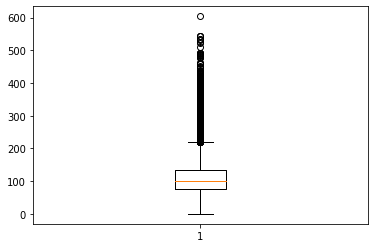

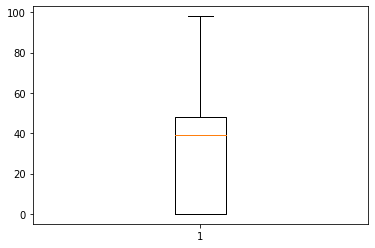

In [43]:
outlierdata = dataset[dataset.FACTURA_CLASE_DOCUMENTO_ID == 'ZTON']
# Univariate outlier detection
plt.boxplot(outlierdata['IMP_VENTA_NETO_EUR'])
plt.show()

plt.boxplot(outlierdata['EDAD_COMPRA'])
plt.show()

For EDAD_COMPRA, we don't have any possible outlier. Otherwise, In IMP_VENTA_NETO_EUR, I have found possible outliers, let's analyse them.




In [44]:
print(outlierdata[outlierdata.IMP_VENTA_NETO_EUR >=400][['IMP_VENTA_NETO_EUR', 'PRODUCTO_ID', 'CATEGORIA', 'NUMERO_DEUDOR_PAIS_ID', 'JERARQUIA_PROD_ID', 'GRUPO_ARTICULO_PRODUCTO_ID', 'GRUPO_ARTICULO']].sort_values(by = 'IMP_VENTA_NETO_EUR',ascending=False).head(10))
print('')
print(outlierdata[['IMP_VENTA_NETO_EUR', 'PRODUCTO_ID', 'CATEGORIA', 'NUMERO_DEUDOR_PAIS_ID', 'JERARQUIA_PROD_ID', 'GRUPO_ARTICULO_PRODUCTO_ID', 'GRUPO_ARTICULO']].sort_values(by = 'IMP_VENTA_NETO_EUR',ascending=True).head(10))
print('')
print('Number of products cheaper than 10€: '+str(outlierdata[outlierdata.IMP_VENTA_NETO_EUR < 10].count().IMP_VENTA_NETO_EUR))

         IMP_VENTA_NETO_EUR  PRODUCTO_ID         CATEGORIA  \
297352               603.96  K300325-003      Men Mid Boot   
679329               543.25  K300359-003    Men Ankle Boot   
679303               543.25  K400531-003  Women Ankle Boot   
677298               543.25  K400531-002  Women Ankle Boot   
1255741              534.66  K400395-002   Women High Boot   
1127325              533.00  K300310-001    Men Ankle Boot   
1098327              532.14  K300304-003    Men Ankle Boot   
1275808              525.21  K400395-002   Women High Boot   
26114                520.84  K400395-002   Women High Boot   
945450               509.97  K400467-003    Women Mid boot   

        NUMERO_DEUDOR_PAIS_ID   JERARQUIA_PROD_ID GRUPO_ARTICULO_PRODUCTO_ID  \
297352                     CH  101TOGTOGKHK300325                        1.0   
679329                     JP  101WDNWDN0HK300359                        1.0   
679303                     JP  101WDNWDN0MK400531                        1.0 

Looking at the table above, I have found some products that are very expensive, as my main aim of the project is to predict the shoes sold, I am can remove the product which don't have the category of shoes.

Category Summarize:
- 01 -> Zapatos Adulto
- 02 -> Ropa
- 03 -> Zapatos Factorys (producto que se fabrica expresamente para Outlets)
- 04 -> Bolsos
- 05 -> Complementos (Accesorios)
- 06 -> Complementos VOR (Accesorios Volvo Ocean Race)
- 07 -> PLV
- 08 -> Kids
- 10 -> First Walkers

I am not interested in 2, 5, 6 and 7. So I am going to remove them from my dataset. Moreover, I will remove the values which have IMP_VENTA_NETO_EUR less than 10€, such that they are errors (not possible).

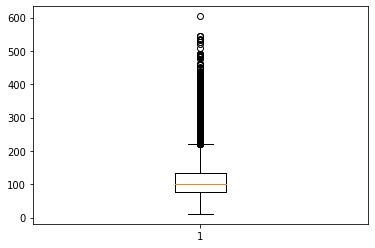

         IMP_VENTA_NETO_EUR  PRODUCTO_ID         CATEGORIA  \
297352               603.96  K300325-003      Men Mid Boot   
679329               543.25  K300359-003    Men Ankle Boot   
679303               543.25  K400531-003  Women Ankle Boot   
677298               543.25  K400531-002  Women Ankle Boot   
1255741              534.66  K400395-002   Women High Boot   
1127325              533.00  K300310-001    Men Ankle Boot   
1098327              532.14  K300304-003    Men Ankle Boot   
1275808              525.21  K400395-002   Women High Boot   
26114                520.84  K400395-002   Women High Boot   
945450               509.97  K400467-003    Women Mid boot   

        NUMERO_DEUDOR_PAIS_ID   JERARQUIA_PROD_ID GRUPO_ARTICULO_PRODUCTO_ID  \
297352                     CH  101TOGTOGKHK300325                        1.0   
679329                     JP  101WDNWDN0HK300359                        1.0   
679303                     JP  101WDNWDN0MK400531                        1.0 

In [49]:
outlierdata = outlierdata[(~outlierdata.GRUPO_ARTICULO_PRODUCTO_ID.isin([2, 5, 6, 7])) & (outlierdata.IMP_VENTA_NETO_EUR >= 10)]
plt.boxplot(outlierdata['IMP_VENTA_NETO_EUR'])
plt.show()
print(outlierdata[outlierdata.IMP_VENTA_NETO_EUR >=400][['IMP_VENTA_NETO_EUR', 'PRODUCTO_ID', 'CATEGORIA', 'NUMERO_DEUDOR_PAIS_ID', 'JERARQUIA_PROD_ID', 'GRUPO_ARTICULO_PRODUCTO_ID', 'GRUPO_ARTICULO']].sort_values(by = 'IMP_VENTA_NETO_EUR',ascending=False).head(10))
print('')
print(outlierdata[['IMP_VENTA_NETO_EUR', 'PRODUCTO_ID', 'CATEGORIA', 'NUMERO_DEUDOR_PAIS_ID', 'JERARQUIA_PROD_ID', 'GRUPO_ARTICULO_PRODUCTO_ID', 'GRUPO_ARTICULO']].sort_values(by = 'IMP_VENTA_NETO_EUR',ascending=True).head(10))

Finally, all the possible outliers have been removed, I cannot consider the remaining values as outliers such that all of them are possible, (responsable camper said)

In [52]:
dataset = outlierdata.drop(columns = ['GRUPO_ARTICULO'])

## Data Insights

Now, I am going to analyse the profit by year. As I said before, I use CANAL_VENTA_ID = 20 (Online). Total year (2018) profit is more or less 24 milions of €/$ (?). So now, I will analyse in which months they earn more money. After, I will see what is the percentage got in each month from the total earnings.

Total year profit: 93320880.18€


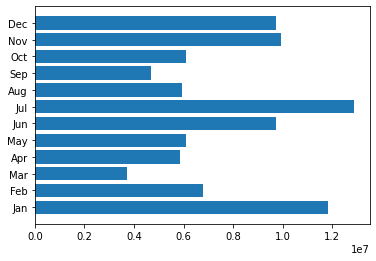

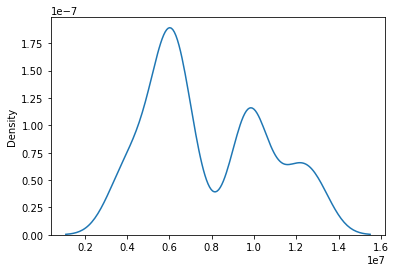

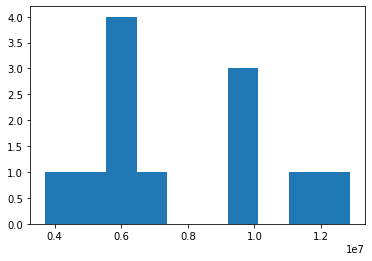

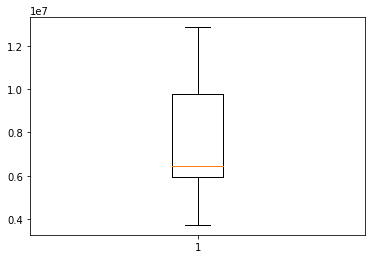

Benefit from each month(%):
Jan: 12.67% from total sales
Feb: 7.28% from total sales
Mar: 3.99% from total sales
Apr: 6.29% from total sales
May: 6.54% from total sales
Jun: 10.42% from total sales
Jul: 13.78% from total sales
Aug: 6.38% from total sales
Sep: 5.02% from total sales
Oct: 6.54% from total sales
Nov: 10.64% from total sales
Dec: 10.44% from total sales


In [10]:
total_year_sold = round(dataset.IMP_VENTA_NETO_EUR.sum(),2)
print('Total year profit: '+str(total_year_sold)+'€')
total_month_sold = round(dataset.groupby(['MES_FACTURA']).IMP_VENTA_NETO_EUR.sum(),2)
total_month_sold = np.array(total_month_sold)
name_months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.barh(name_months, total_month_sold)
plt.show()

sns.kdeplot(total_month_sold, bw=0.3) # 0.2
plt.show()

plt.hist(total_month_sold, align= 'mid')
plt.show()

plt.boxplot(total_month_sold)
plt.show()

print('Benefit from each month(%):')
for i in range(0, 12):
    print(name_months[i]+': '+str(round(total_month_sold[i]/(total_year_sold)*100,2))+'% from total sales')

It can be seen in the first graph, the months where the profit is higher are January, June and July. Probably this is because the discounts they do (Sales), we will see it later.
As you can see in the second (density plot) and third (histogram plot) the distribution of the data. If I plot the distribution in quartiles, I can see that the median is closer to the lower quartile, I don't have outliers but the maximum value is large and far from the 3rd quartile.

Finally, Among Jan, June and July, Camper earns the 40% of the total year. It will be interesing to see if this happens in the next years (2019, 2020).

Now, I am going to extract are the bests selling products during the year. I have seen that there are products that are in negative, I think there are two reasons, or these products are sold in other year and this year the customer is returning the product (Weird but possible) or it is possible that the customers bought the product in site and they are returning the products via online.

SHOULD I INVESTIGATE IT? Well, it is possible that the data is wrong.

The top ten products are:

In [11]:
product_sales_year = round(dataset.groupby(['PRODUCTO_ID']).IMP_VENTA_NETO_EUR.sum(), 2)
top_product_sales = product_sales_year.sort_values(ascending = False).head(10)
print(product_sales_year.sort_values(ascending = False).head(10))

PRODUCTO_ID
21595-018      337023.68
17665-014      275662.45
18811-033      274601.03
K100243-001    257690.57
20848-017      251168.81
K200387-004    215366.89
16002-203      211899.40
17665-011      204623.17
18751-048      199783.48
K400325-004    194681.57
Name: IMP_VENTA_NETO_EUR, dtype: float64


It is interesting to see which are the bests selling products each month, in this way, we will be able to see if there's any month where the product hits a maximum. I will be focused on the top ten products. It is possible to do this for each product, in this way I would discover if there are any product that during the year has lower sells but when it is in sales, it has a boom. I AM NOT SURE ABOUT DOING THIS FOR EACH PRODUCT, BY THE MOMENT ONLY FOR TOP 10.

In [12]:
product_sales_month = dataset.groupby(['MES_FACTURA','PRODUCTO_ID']).IMP_VENTA_NETO_EUR.sum()
product_sales_month = pd.DataFrame(product_sales_month)
months = []
product_id = []
money = []

for k, v in zip(product_sales_month.index, product_sales_month.IMP_VENTA_NETO_EUR):
    months.append(k[0])
    product_id.append(k[1])
    money.append(v)

In [13]:
product_month_sales = pd.DataFrame({
    'Month': months,
    'Product': product_id,
    'Money': money
})
for i in range(0, len(top_product_sales)):
    val_money = round(product_month_sales[(product_month_sales.Product == top_product_sales.index[i])].Money.max(), 2)
    print(product_month_sales[(product_month_sales.Product == top_product_sales.index[i]) & (product_month_sales.Money.astype(int) == val_money.astype(int))])    

       Month    Product     Money
14210      4  21595-018  46570.88
       Month    Product     Money
26130      7  17665-014  44009.12
       Month    Product     Money
46899     12  18811-033  75619.33
       Month      Product     Money
27556      7  K100243-001  33088.23
       Month    Product     Money
13993      4  20848-017  36431.44
       Month      Product     Money
15832      4  K200387-004  34352.41
       Month    Product    Money
26074      7  16002-203  36086.7
       Month    Product     Money
26129      7  17665-011  26964.13
       Month    Product     Money
26297      7  18751-048  23114.51
       Month      Product     Money
45968     11  K400325-004  62223.12


Looking at the results, 8/10 products are top sellers in jAN/June/July (Sales).

Now, I am going to analyse which season is more successful.

In [14]:
temporada_sales_year = dataset.groupby(['TEMPORADA_COMERCIAL_ID']).IMP_VENTA_NETO_EUR.sum()
for k, v in zip(temporada_sales_year.index, temporada_sales_year):
    if k % 2 == 0:
        print('Temporada Primavera-Verano: '+str(round(v,2))+'€')
    else:
        print('Temporada Otoño-Invierno: '+str(round(v,2))+'€')

Temporada Otoño-Invierno: 5551604.69€
Temporada Primavera-Verano: 11833549.42€
Temporada Otoño-Invierno: 13794184.6€
Temporada Primavera-Verano: 13427476.5€
Temporada Otoño-Invierno: 16004283.17€
Temporada Primavera-Verano: 18977764.34€
Temporada Otoño-Invierno: 13732017.46€


In 2018, I have three commercial seasons (85, 86, 87).

In [15]:
temporada_sales_month = dataset.groupby(['MES_FACTURA', 'TEMPORADA_COMERCIAL_ID']).IMP_VENTA_NETO_EUR.sum()
months = []
sales = []
season = []
for k, v in zip(temporada_sales_month.index, temporada_sales_month):
    if v != 0:
        months.append(k[0])
        season.append(k[1])
        sales.append(v)
season_month_sales = pd.DataFrame({
    'Month': months,
    'Season': season,
    'Money': sales
})
name_months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.barh(name_months, season_month_sales.Money, color= season_month_sales['Season'].map({85: 'red', 86: 'blue', 87: 'green'}))
plt.show()

sns.kdeplot(temporada_sales_month, bw=0.3) # 0.2
plt.show()

plt.hist(temporada_sales_month, align= 'mid')
plt.show()

ValueError: shape mismatch: objects cannot be broadcast to a single shape

In the first graphic you have the representation of the total sales by month considering each season. (85->red, 86->blue, 87->green).
As it can be seen in the distribution, it looks like a bimodal representation, where it reveals that there are two different types, when it is sales and when it is not. However there are only 3 months of sales, it conditions the density plot because they have a lot of weight (high volume).

Let's analyse the column called TALLA. As I haven't treat yet the missing values, by the moment I am not considering them.

In [16]:
size_sales = dataset.groupby(['TALLA']).IMP_VENTA_NETO_EUR.sum()
size_sales
sales = []
size = []
for k, v in zip(size_sales.index, size_sales):
    if v != 0:
        size.append(k)
        sales.append(v)
size_sales = pd.DataFrame({
    'Size': size,
    'Money': sales
})

plt.bar(size_sales.Size, size_sales.Money, alpha=0.2)
plt.tick_params(axis='x', which='major', labelsize=4)
plt.show()

TypeError: the dtypes of parameters x (object) and width (float64) are incompatible

I can see which size is the most sold for each product. As the size of the dataframe is really big, it would be better to ask if they are interested in any product to filter.

In [17]:
product_size_sales = dataset.groupby(['PRODUCTO_ID', 'TALLA']).IMP_VENTA_NETO_EUR.sum()
product_size_sales
products = []
sizes = []
sales = []

for k, v in zip(product_size_sales.index, product_size_sales):
    if v != 0:
        products.append(k[0])
        sizes.append(k[1])
        sales.append(v)
product_size_sales = pd.DataFrame({
    'Product': products,
    'Size': sizes,
    'Money': sales
})

product_size_sales['max'] = product_size_sales.groupby(['Product']).Money.transform(max)
products = []
sizes = []
sales = []
for _, v in product_size_sales.iterrows():
    if int(v['Money']) == int(v['max']):
      products.append(v['Product'])
      sizes.append(v['Size'])
      sales.append(v['Money'])

size_most_sold = pd.DataFrame({
    'Product': products,
    'Size': sizes,
    'Money': sales
})


Now, I am going to see the distribution of the data grouped by the genre. Same as before, I haven't treated the null variables yet so I am not considering them.

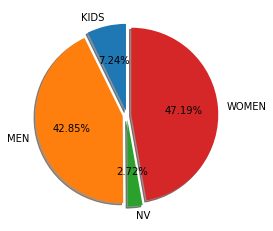

In [18]:
genre_sales_year = dataset.groupby(['GENERO_PRODUCTO']).IMP_VENTA_NETO_EUR.sum()
genre = []
sales = []
for k, v in zip(genre_sales_year.index, genre_sales_year):
    genre.append(k)
    sales.append(v)
genre_sales_year = pd.DataFrame({
    'Genero': genre,
    'Money': sales
})
plt.pie(genre_sales_year.Money, explode=(0.05, 0.05, 0.05, 0.05), labels= genre_sales_year.Genero, autopct='%1.2f%%', shadow= True, startangle= 90)
plt.show()

Looking at the pie chart, women are the most sold, with an almost the 50%, men are the next one with 43%. The genre kids is the worst in terms of sells. The market should be oriented in men and women. Also, they can extract from the data that one open market to exploit is Kids.

TEMPORADA_COMERCIAL_ID  GENERO_PRODUCTO
85                      KIDS               3.903310e+05
                        MEN                2.503177e+06
                        NV                 6.972067e+04
                        WOMEN              2.609014e+06
86                      KIDS               1.045030e+06
                        MEN                4.860120e+06
                        NV                 2.676539e+05
                        WOMEN              5.701408e+06
87                      KIDS               1.038620e+06
                        MEN                6.049676e+06
                        NV                 3.086831e+05
                        WOMEN              6.408583e+06
88                      KIDS               1.113263e+06
                        MEN                5.838871e+06
                        NV                 2.634956e+05
                        WOMEN              6.220878e+06
89                      KIDS               1.164742e+06
        

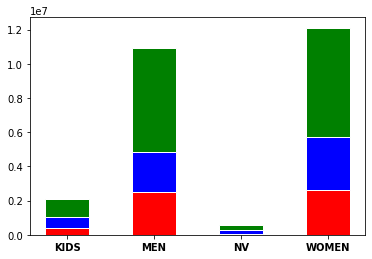

In [19]:
genre_season_sales = dataset.groupby(['TEMPORADA_COMERCIAL_ID', 'GENERO_PRODUCTO']).IMP_VENTA_NETO_EUR.sum()
print(genre_season_sales)
genre = []
seasons = []
sales = []
for k, v in zip(genre_season_sales.index, genre_season_sales):
    seasons.append(k[0])
    genre.append(k[1])
    sales.append(v)
genre_sales_year = pd.DataFrame({
    'Season': seasons,
    'Genero': genre,
    'Money': sales
})
plt.bar([0, 1, 2, 3], genre_sales_year[genre_sales_year.Season == 85].Money, color= 'red', edgecolor='white', width=0.5)
plt.bar([0, 1, 2, 3], genre_sales_year[genre_sales_year.Season == 86].Money, color= 'blue', bottom=genre_sales_year[genre_sales_year.Season == 85].Money, edgecolor='white', width=0.5)
plt.bar([0, 1, 2, 3], genre_sales_year[genre_sales_year.Season == 87].Money, color= 'green', bottom=genre_sales_year[genre_sales_year.Season == 86].Money, edgecolor='white', width=0.5)
plt.xticks([0, 1, 2, 3], ['KIDS', 'MEN', 'NV','WOMEN'], fontweight='bold')
#plt.xlabel("Season")
plt.show()

Checking the results, (season: 85->red, 86->blue, 87->green). In all cases, the best season has been 87 (Otoño-Invierno). Also, the sales from Woman genre are always greater than the others not matter the season. We can see clearly the difference between the KIDS genre and the other two, as I commented previously.

Average customer age: 32.0
  Age_Range         Money
0     19 --  1.887579e+05
1     20-29  4.838079e+06
2     30-39  1.594429e+07
3     40-49  2.348316e+07
4     50-59  1.418877e+07
5     60-69  5.953407e+06
6     70 ++  2.125732e+06
7        NS  2.766891e+07


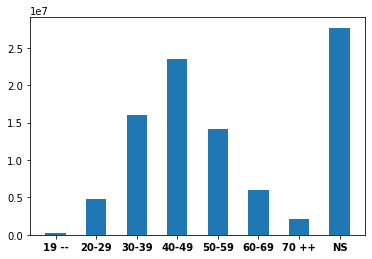

In [20]:
print('Average customer age: '+str(round(dataset.EDAD_COMPRA.mean(), 0)))
age_range_sales = dataset.groupby(['EDAD_RANGO_COMPRA']).IMP_VENTA_NETO_EUR.sum()
money = []
age_range = []
for k, v in zip(age_range_sales.index, age_range_sales):
    money.append(v)
    age_range.append(k)
age_grouped_sales = pd.DataFrame({
    'Age_Range': age_range,
    'Money': money
})
print(age_grouped_sales)
plt.bar([0, 1, 2, 3, 4, 5, 6, 7], age_grouped_sales.Money, width=0.5)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7], ['19 --','20-29','30-39','40-49','50-59','60-69','70 ++','NS'], fontweight='bold')
plt.show()

As it can be seen in the image above, the graphic of the money earned for each size is following a Gaussian distribution, also there are a lot of non informed size of the product, that's the reason why the bar NS (no informado) has almost the same value of the most sold size (40-49). Without paying attention to the NS', the market should be oriented for people between 30 to 59 years.

Now, I am going to analyse the sales across all the countries where Camper is selling products.

In [21]:
total_sales_country = round(dataset.groupby(['NUMERO_DEUDOR_PAIS_ID']).IMP_VENTA_NETO_EUR.sum(), 2)
print('Top 10 countries: ')
print(total_sales_country.sort_values(ascending = False).head(10))
month_sales_country = round(dataset.groupby(['NUMERO_DEUDOR_PAIS_ID', 'MES_FACTURA']).IMP_VENTA_NETO_EUR.sum(),2)
money = []
month = []
country=[]
for k, v in zip(month_sales_country.index, month_sales_country):
    money.append(v)
    month.append(k[1])
    country.append(k[0])
country_month_sales = pd.DataFrame({
    'Country': country,
    'Month': month,
    'Money': money
})
#Analysee, country+genre+product+age range

Top 10 countries: 
NUMERO_DEUDOR_PAIS_ID
US    14050387.55
ES    11827269.66
GB    10797299.84
DE     9014418.76
FR     5335139.07
IT     5315056.09
JP     4832753.47
TR     3951066.07
AU     3911315.08
CA     2913753.80
Name: IMP_VENTA_NETO_EUR, dtype: float64


In [22]:
# Analysee, country+genre+product+age range
country_genre_product_age = round(dataset.groupby(['NUMERO_DEUDOR_PAIS_ID', 'GENERO_PRODUCTO', 'PRODUCTO_ID', 'EDAD_RANGO_COMPRA']).IMP_VENTA_NETO_EUR.sum(), 2)
money = []
product = []
country=[]
genre_product = []
age_range = []
for k, v in zip(country_genre_product_age.index, country_genre_product_age):
    money.append(v)
    country.append(k[0])
    genre_product.append(k[1])
    product.append(k[2])
    age_range.append(k[3])

country_genre_product_age = pd.DataFrame({
    'Country': country,
    'Genre_product': genre_product,
    'Product': product,
    'Age_range': age_range,
    'Money': money
})

In [23]:
language_analysis = dataset.groupby(['IDIOMA_CONTACTO']).agg({'FACTURA_ID':'count'}).reset_index().rename(columns= {'FACTURA_ID': 'Count'})
print('Language not informed: '+language_analysis[language_analysis.IDIOMA_CONTACTO == 'NV']['Count'].to_string(index=False))
print('Top 3 most used language:')
print(language_analysis[language_analysis.IDIOMA_CONTACTO != 'NV'].sort_values(by=['Count'] ,ascending = False).head(3))

Language not informed: 3561
Top 3 most used language:
   IDIOMA_CONTACTO   Count
9               EN  594408
7               DE  202158
10              ES  180142


Queda acabar de treure insights de les dades

PCA

In [24]:
# var to cat
# como que lo que quiero es ver las variables que me interesan para el modelo, solo uso las ventas, el modelo tiene que predecir las ventas de un producto y una talla
pcadataset = dataset[dataset.FACTURA_CLASE_DOCUMENTO_ID == 'ZTON']
pcadataset = pcadataset.drop(columns=['FACTURA_ID', 'FACTURA_POSICION_ID', 'CUSTOMER_ID', 'FACTURA_CLASE_DOCUMENTO_ID', 'COLOR', 'ANO_FACTURA', 'CANAL_VENTA_ID', 'VENTA_DEVOLUCION'])
pcadataset['FECHA_FACTURA'] =  pcadataset['FECHA_FACTURA'].str.split('-', expand = True)[2]
pcadataset.PRODUCTO_ID = pcadataset['PRODUCTO_ID'].astype('category')
pcadataset.TALLA = pcadataset['TALLA'].astype('category')
pcadataset.ESFUERZO_VENTA_ID = pcadataset['ESFUERZO_VENTA_ID'].astype('category')
pcadataset.NUMERO_DEUDOR_PAIS_ID = pcadataset['NUMERO_DEUDOR_PAIS_ID'].astype('category')
pcadataset.JERARQUIA_PROD_ID = pcadataset['JERARQUIA_PROD_ID'].astype('category')
pcadataset.GRUPO_ARTICULO_PRODUCTO_ID = pcadataset['GRUPO_ARTICULO_PRODUCTO_ID'].astype('category')
pcadataset.GENERO_PRODUCTO = pcadataset['GENERO_PRODUCTO'].astype('category')
pcadataset.CATEGORIA = pcadataset['CATEGORIA'].astype('category')
pcadataset.TIPOLOGIA = pcadataset['TIPOLOGIA'].astype('category')
pcadataset.CONSUMER_COLOR = pcadataset['CONSUMER_COLOR'].astype('category')
pcadataset.CONTACTO_SN = pcadataset['CONTACTO_SN'].astype('category')
pcadataset.EDAD_SN = pcadataset['EDAD_SN'].astype('category')
pcadataset.GENERO_CONTACTO = pcadataset['GENERO_CONTACTO'].astype('category')
pcadataset.EDAD_RANGO_COMPRA = pcadataset['EDAD_RANGO_COMPRA'].astype('category')
pcadataset.CIUDAD_CONTACTO = pcadataset['CIUDAD_CONTACTO'].astype('category')

In [25]:
# Encode 2-values labels
label_encoder = preprocessing.LabelEncoder()
pcadataset['CONTACTO_SN'].replace(to_replace= 'S', value = 1, inplace = True)
pcadataset['CONTACTO_SN'].replace(to_replace= 'N', value = 0, inplace = True)
pcadataset['EDAD_SN'].replace(to_replace= 'S', value = 1, inplace = True)
pcadataset['EDAD_SN'].replace(to_replace= 'N', value = 0, inplace = True)
pcadataset["GENERO_PRODUCTO"] = label_encoder.fit_transform(pcadataset[["GENERO_PRODUCTO"]])
pcadataset["GENERO_CONTACTO"] = label_encoder.fit_transform(pcadataset[["GENERO_CONTACTO"]])
pcadataset["TALLA"] = label_encoder.fit_transform(pcadataset[["TALLA"]])
pcadataset["PRODUCTO_ID"] = label_encoder.fit_transform(pcadataset[["PRODUCTO_ID"]])
pcadataset["ESFUERZO_VENTA_ID"] = label_encoder.fit_transform(pcadataset[["ESFUERZO_VENTA_ID"]])
pcadataset["JERARQUIA_PROD_ID"] = label_encoder.fit_transform(pcadataset[["JERARQUIA_PROD_ID"]])
pcadataset["CATEGORIA"] = label_encoder.fit_transform(pcadataset[["CATEGORIA"]])
pcadataset["TIPOLOGIA"] = label_encoder.fit_transform(pcadataset[["TIPOLOGIA"]])
pcadataset["CONSUMER_COLOR"] = label_encoder.fit_transform(pcadataset[["CONSUMER_COLOR"]])
pcadataset["CIUDAD_CONTACTO"] = label_encoder.fit_transform(pcadataset[["CIUDAD_CONTACTO"]])
pcadataset["IDIOMA_CONTACTO"] = label_encoder.fit_transform(pcadataset[["IDIOMA_CONTACTO"]])
#dl = {'IL': 972, 'Jerusalem': 9722, 'IE': 353, 'Dublin 8': 3531, 'CA': 1, 'Vancouver': 1250, 'AT': 43, 'Perchtoldsdorf': 431, 'Wien': 431, 'PL': 48, '?omianki': 4822, 'Bojano': 4822, 'CH': 41, 'Thalwil': 4143, 'Z?rich': 4143, 'Bottighofen': 4143, 'Dinhard': 4150, 'Allschwil ': 4123, 'Glarus': 4155, 'Basel': 4161, 'Eglisau ': 4143, 'Chavannes-pr?s-Renens': 4122, 'Baden': 4156, 'Wettingen': 4130, 'Corpataux': 4126, 'Tramelan': 4132, 'Les Paccots': 4119, 'Greifensee': 4144, 'RO': 40, 'Bucharest': 4021, 'Sementina': 4114, 'Baar': 4141, 'NV': 4100, 'winterthur': 4152, 'Geneva': 4122, 'Ursy': 4100, 'Satigny': 4142, 'Lausanne': 4121, 'Amriswil': 4171, 'bern': 4131, 'D?bendorf ': 4144, 'D?rnten': 4155, 'Yens': 4121, 'Auvernier': 4101, 'Lutry': 4195, 'Monthey': 4124, 'Bulle': 4126, 'Grosswangen': 4190, 'Bellinzona': 4191, 'Vevey': 4121, 'Ueken': 4162, 'Netstal': 4190, 'Fribourg': 4126, 'Saillon': 4190, 'Thun': 4133, 'Niederrohrdorf': 4156, '': , '': , '': , '': , '': , '': , '': , '': , '': , '': , '': , '': , '': , '': , '': , '': , '': , '': , '': , '': , '': , '': , '': , '': , '': , '': , '': , '': , '': , '': , '': , '': , '': , '': , '': , '': , '': , '': , '': , '': , '': , '': , '': , '': , '': , '': , '': , '': , '': , '': , '': , '': , '': , '': , '': , '': , '': , '': , '': , '': , '': , '': , '': , '': , '': , '': , '': , '': , '': , '': , '': , '': , '': , '': , '': , '': , '': , '': , '': , '': ,}
pcadataset["NUMERO_DEUDOR_PAIS_ID"] = label_encoder.fit_transform(pcadataset[["NUMERO_DEUDOR_PAIS_ID"]])
pcadataset.to_csv('info_datav2.csv', index = False, header=True)
pcadataset = pcadataset.drop(columns=['EDAD_RANGO_COMPRA', 'PRODUCTO_ID'])

TypeError: Encoders require their input to be uniformly strings or numbers. Got ['float', 'str']

In [26]:
# Scale numeric data
scaler = StandardScaler()
scaled = pd.DataFrame(scaler.fit_transform(pcadataset), columns = pcadataset.columns)

ValueError: could not convert string to float: '18751-071'

In [25]:
pca = PCA()
principalComponents = pca.fit_transform(scaled)

In [26]:
print ('Proportion of Variance Explained : ', pca.explained_variance_ratio_)  
print('')
out_sum = np.cumsum(pca.explained_variance_ratio_)  
print ('Cumulative Prop. Variance Explained: ', out_sum)
print('')
print('Explained variance: ', pca.explained_variance_)

In [27]:
loadings = pca.components_
num_pc = pca.n_features_
pc_list = ["PC"+str(i) for i in list(range(1, num_pc+1))]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df['variable'] = pcadataset.columns.values
loadings_df = loadings_df.set_index('variable')

In [28]:
ax = sns.heatmap(loadings_df, annot=False, cmap='Spectral', xticklabels=True, yticklabels=True)
plt.tick_params(axis='x', which='major', labelsize=4)
plt.tick_params(axis='y', which='major', labelsize=3)
plt.show()

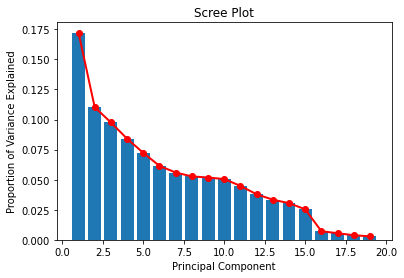

In [29]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.bar(PC_values, pca.explained_variance_ratio_)
plt.show()

In [30]:
cluster.pcaplot(x=loadings[0], y=loadings[1], labels=pcadataset.columns.values, var1=round(pca.explained_variance_ratio_[0]*100, 2), var2=round(pca.explained_variance_ratio_[1]*100, 2), show= True)
cluster.pcaplot(x=loadings[0], y=loadings[1], labels=pcadataset.columns.values, var1=round(pca.explained_variance_ratio_[0]*100, 2), var2=round(pca.explained_variance_ratio_[1]*100, 2))

In [31]:
colors = label_encoder.fit_transform(dataset[dataset.FACTURA_CLASE_DOCUMENTO_ID == 'ZTON']["PRODUCTO_ID"])
plt.figure(figsize=(8,6))
plt.scatter(principalComponents[:,0], principalComponents[:,1],c=colors, cmap='rainbow')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')
plt.savefig('PCA.png')

In [32]:
colors = label_encoder.fit_transform(dataset[dataset.FACTURA_CLASE_DOCUMENTO_ID == 'ZTON']["PRODUCTO_ID"])
#cluster.biplot(cscore=principalComponents, loadings=loadings, labels=pcadataset.columns.values, var1=round(pca.explained_variance_ratio_[0]*100, 2),
#var2=round(pca.explained_variance_ratio_[1]*100, 2), show= True)
cluster.biplot(cscore=principalComponents, loadings=loadings, labels=pcadataset.columns.values, var1=round(pca.explained_variance_ratio_[0]*100, 2),
var2=round(pca.explained_variance_ratio_[1]*100, 2), show= False)

In [33]:
# Export save info data
scaled.to_csv('info_data.csv', index = False, header=True)

In [34]:
numdeu = dataset[dataset.FACTURA_CLASE_DOCUMENTO_ID == 'ZTON'][['NUMERO_DEUDOR_PAIS_ID', 'CIUDAD_CONTACTO']]